In [1]:
import pysam
import collections
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import time
from sklearn import metrics
%matplotlib inline

**User Edit the following cell:**

In [2]:
# folder containing the bamfiles
bam_folder = './spikein_from_bob/'

# folder to write output files to
output_folder = './results'

# enter the input and cmc files
# make sure to order them in correct paired order
input_files = ['HG_input_filtered.bam','HG_FA_input_filtered.bam','LG_input_filtered.bam','LG_FA_input_filtered.bam']
cmc_files = ['HG_CMC_filtered.bam','HG_FA_CMC_filtered.bam','LG_CMC_filtered.bam','LG_FA_CMC_filtered.bam']
# names for each experiment in same order as files
exp_names = ['HG', 'HG_FA', 'LG', 'LG_FA']

# window size for calculating peak values by Carlile method
window_size = 20 

# set to True if want to add +1 pseudocount for each position end count
# will also add pseudocount reads for the overlap count (Schwartz method) based on average aligned read length
pseudocount = True
average_aligned_read_length = 67

# file containing known sites
# set as '' if don't want to include known sites
known_sites_file = 'Carlile_known_human_SuppT7_updated.csv'

In [16]:
def create_folders(folder_paths):
    '''
    Given: list of folders (with paths)
    Check if folder already exists, if not mkdir folder
    '''
    for folder_path in folder_paths:
        try:
            os.mkdir(folder_path)
            print(f'created new folder {folder_path}')
        except FileExistsError:
            print(f'{folder_path} already exists')
        if not os.path.isdir(folder_path):
            os.mkdir(folder_path)

In [17]:
end_counts_folder = os.path.join(output_folder, 'end_counts') # just the raw end counts
end_count_scores_folder = os.path.join(output_folder, 'end_count_scores') # includes pseudocounts, scaled_data, peak values, etc

plots_folder = os.path.join(output_folder, 'plots')

# check if ouput folder already exists
if os.path.isdir(output_folder):
    print(f'Warning: {output_folder} already exists - any same name files will be overwritten')
create_folders([output_folder, end_counts_folder, end_count_scores_folder, plots_folder])

./results already exists
./results/end_counts already exists
./results/end_count_scores already exists
./results/plots already exists


In [5]:
# get the full filenames including path
bamfiles = [os.path.join(bam_folder, bamfile) for bamfile in input_files + cmc_files]

# get just the sample name from the filename
input_samples = [file.split('.')[0] for file in input_files]
cmc_samples = [file.split('.')[0] for file in cmc_files]
samples = input_samples + cmc_samples
sample_overlaps = [f'{sample}_overlap' for sample in samples]

exp_peaks = [f'{i}_Peak_ws{window_size}' for i in exp_names]
exp_input_peaks = [f'{i}_Input_Peak_ws{window_size}' for i in exp_names] # used for ROC analysis

input_psi_ratios = [f'{i}_psi_ratio' for i in input_samples]
cmc_psi_ratios = [f'{i}_psi_ratio' for i in cmc_samples]
exp_psi_fold_changes = [f'{i}_psi_fold_change' for i in exp_names]

In [6]:
# get the reference names from a bam file
samfile = pysam.AlignmentFile(bamfiles[0], 'rb')
ref_names = samfile.references

# make a dict to convert the long name to a short abbreviation (if aligned to rRNA)
rrnas = ('5-8S','18S','28S')
ref_name_to_abbrev = {}
for ref_name in ref_names:
    found_rrnas = [rrna for rrna in rrnas if rrna in ref_name]
    if len(found_rrnas) > 1:
        raise SystemError(f'Found multiple rRNA names in {ref_name}')
    if not found_rrnas:
        print(f'Warning: did not find expected rRNA name in {ref_name}')
        ref_name_to_abbrev[ref_name] = ref_name
    else:
        ref_name_to_abbrev[ref_name] = found_rrnas[0]

# ref_names will be 5-8S, 18S, 28S if aligned only to rRNA
ref_names = ref_name_to_abbrev.values()

In [7]:
# read in known Psi sites from Bob's updating of Carlile supplementary table 7
# Bob's positions are in the 'NCBI tx pos' column
# store them in abbrev_ref_to_known {abbrev_ref: [list of known sites]}
rrna_to_known = {}

if known_sites_file:
    known_df = pd.read_csv(known_sites_file)
    
    for rrna in rrnas:
        vals = known_df[known_df['gene name'].str.contains(rrna)]['NCBI tx pos'].values
        rrna_to_known[rrna] = vals

In [8]:
def get_end_count(bamfile, ref_name_to_abbrev, ref_df, sample, sample_overlap):
    '''
    Given: bamfile for a particular sample
    Gets 5' R1 end counts
    Updates pandas dataframe with end counts
    Updates how often each position overlaps a read for Schwartz method
    Dataframe is modified in place
    Returns: average aligned read length for adding read pseudocounts for Schwartz method
    '''
    samfile = pysam.AlignmentFile(bamfile, 'rb')
    reads = samfile.fetch()
    print(bamfile)
    
    total_ref_length = n_reads = 0

    for read in reads:

        if read.is_read1 and not read.is_reverse:
            n_reads += 1
            total_ref_length += read.reference_length
            
            ref = ref_name_to_abbrev[read.reference_name]
            pos = read.reference_start + 1 # Read 1, 5-prime (add 1 since pysam 0-based)
            base = read.get_reference_sequence()[0].upper()
            
            df = ref_df[ref]
            df.loc[pos:read.reference_end+1, sample_overlap] +=1 # for Schwartz method
            df.loc[pos, sample] += 1

            previous_base = df.at[pos, 'Sequence']

            if previous_base != 0:
                if previous_base != base:
                    raise SystemError(f'Different bases found at position {pos}: current={base} previous={previous_base}')
            else:
                df.loc[pos, 'Sequence'] = base
                
    return (total_ref_length / n_reads)

In [9]:
def scale_input(ref_df, input_name, cmc_name, exp_name):
    '''
    Given: dictionary {ref_name: df}, and a pair of input/cmc names
    Scale input to be same total reads as cmc for each input/cmc pair
    df is modified in-place in function (don't need to return it)
    New columns '_scaled' are added
    '''
    # get total reads for input and CMC over all refs
    cmc_total = input_total = 0
    for df in ref_df.values():
        cmc_total += df[cmc_name].sum()
        input_total += df[input_name].sum()

    ratio = cmc_total / input_total

    # multiply the input reads times the cmc/input ratio
    for df in ref_df.values():  # for each reference gene
        scaled_input = df[input_name].copy()
        scaled_input *= ratio
        df[input_name + '_scaled'] = pd.Series(scaled_input)

    print(f'{exp_name}\t{int(input_total):<8}\t{int(cmc_total):<8}\t{ratio:.4f}')

In [10]:
def get_peak_value(cmc_vals, inp_vals, pos, ws, input_peak=False, verbose=False):
    '''
    Given: series of end counts for cmc/input pair and 
    a position and window-size
    Calculates peak value by looking at the end counts at the 3' base (+1 from given position)
    If input_peak set to True, it will calculate the -CMC peak value from Carlile (used in ROC analysis)
    Returns: peak value
    '''
    pos += 1 # look at 3' base where termination should pile up
    
    if pos > len(cmc_vals): # can't do last base since nothing is 3'
        return np.nan

    r_cmc = cmc_vals.loc[pos]
    r_inp = inp_vals.loc[pos]
    
    # for example if want to look at position 5 with ws=4
    # windows will include positions (3,4,5,6,7)
    lo_pos = max(1, pos - int(ws/2))
    hi_pos = pos + int(ws/2)
    
    wr_cmc = cmc_vals.loc[lo_pos:hi_pos].sum() - r_cmc
    wr_inp = inp_vals.loc[lo_pos:hi_pos].sum() - r_inp

    if (wr_cmc + wr_inp) == 0:
        return np.nan
    
    if input_peak:
        peak = ws * r_inp / (wr_cmc + wr_inp)
    else:
        peak = ws * (r_cmc - r_inp) / (wr_cmc + wr_inp)
        
    if verbose:
        print(f'3-prime position to look at: {pos}')
        print(f'cmc reads at pos {pos}: {r_cmc}')
        print(f'input reads at pos {pos}: {r_inp}')
        print(f'pos: {pos}, lo_pos: {lo_pos}, hi_pos: {hi_pos}')
        print(cmc_vals.loc[lo_pos:hi_pos])
        print(inp_vals.loc[lo_pos:hi_pos])
        print(f'peak: {peak}')
    return peak

In [11]:
def get_psi_ratio(df, samples, sample_overlaps):
    '''
    Given: dataframe for a reference gene and sample
    Calculates psi-ratio which is cmc read / # of reads that overlap that position
    The psi-ratio corresponds to the reads 1bp 3-prime of given position
    New column is added to dataframe with suffix '_psi_ratio'
    '''
    for sample, sample_overlap in zip(samples, sample_overlaps):
        
        #print(sample)
        n_zeros = (df[sample_overlap]==0).astype(int).sum()
        if n_zeros:
            print('There are positions that had 0 read overlaps - consider using pseudocount=True')
        
        psi_ratio = (df[sample] / df[sample_overlap])[1:].values
        # remove first element since we are looking at +1 3' base
        
        # add NaN as last element 
        psi_ratio = np.append(psi_ratio, np.nan)
        df[sample+'_psi_ratio'] = psi_ratio

In [12]:
def get_psi_fold_change(df, exp_names, input_samples, cmc_samples):
    '''
    Given: dataframe and names for all experiments, input samples and cmc samples
    Calculates the psi fold-change by taking log2 (cmc psi-ratio / input psi-ratio)
    New column is added to dataframe with suffix '_psi_fold_change'
    '''
    for exp_name, input_sample, cmc_sample in zip(exp_names, input_samples, cmc_samples):
        df[exp_name+'_psi_fold_change'] = np.log2(df[cmc_sample+'_psi_ratio'] / df[input_sample+'_psi_ratio'])

In [13]:
# This cell will do the end counting for all the bam files
# The raw end count files will be saved as .csv files
# If .csv files already exist, they will read those in instead of redoing the end counting
# For spikein data it takes ~30 minutes to run
# After getting the end counts, pseudocounts will be applied if that option is set to True

if True: # added this to be able to only add pseudocounts once at the end of this cell
    
    # if already csv files in output_folder/end_counts then read those in to dataframe
    if glob.glob(end_counts_folder + '/*.csv'):
        print(f'csv files already exist in {end_counts_folder}')
        print('Reading in those csv files to pandas dataframe')

        ref_df = {}
        for csv_file in glob.glob(end_counts_folder + '/*.csv'):
            print(f'Read in {csv_file}')
            ref_name = os.path.basename(csv_file).split('.')[0]
            df = pd.read_csv(csv_file, index_col=0)
            ref_df[ref_name] = df
    else:
        start_time = time.time()
        ref_df = {}

        # initialize dataframes with zeros
        for ref_name in ref_names:
            ref_df[ref_name] = pd.DataFrame(0, index=np.arange(10000), columns=samples+sample_overlaps+['Sequence'])

        average_read_length = 0
        for sample, sample_overlap, bamfile in zip(samples, sample_overlaps, bamfiles):
            average_read_length += get_end_count(bamfile, ref_name_to_abbrev, ref_df, sample, sample_overlap)
        average_read_length /= len(samples)
        average_read_length = int(average_read_length)
        print(f'Running time: {int((time.time() - start_time)/60)} minutes')

        # trim off all the rows after the last mapped position
        # also trim off the 0 index since we are using 1-based system
        for ref_name in ref_names:
            # trim off the trailing zeros from 'Sequence' to get length of mapped positions
            sequence_array = np.trim_zeros(ref_df[ref_name]['Sequence'], 'b')

            # if 1st element is 0 then remove that row as well
            if sequence_array.iloc[0] == 0:
                ref_df[ref_name] = ref_df[ref_name].loc[1:len(sequence_array)-1]
                # the -1 is because we are removing the first row and that was included in the len(sequence_array)

        for ref_name in ref_names:
            # save dataframe for each reference gene as .csv
            output_name = os.path.join(end_counts_folder, f'{ref_name}.csv')
            ref_df[ref_name].to_csv(output_name)
            
# if pseudocount is True, add +1 to each sample 
if pseudocount:
    print('Adding pseudocounts...')
    for df in ref_df.values():
        for sample in samples: # +1 pseudocounts for end count columns
            df[sample] += 1
        for sample_overlap in sample_overlaps: # +1 over average read length for overlap columns
            for pos in range(1,len(df)):
                df.loc[pos:pos+average_aligned_read_length, sample_overlap] += 1
            
    # also add pseudocounts to sample_overlap columns based on average read alignment length
    
print('Finished')

./spikein_from_bob/HG_input_filtered.bam
./spikein_from_bob/HG_FA_input_filtered.bam
./spikein_from_bob/LG_input_filtered.bam
./spikein_from_bob/LG_FA_input_filtered.bam
./spikein_from_bob/HG_CMC_filtered.bam
./spikein_from_bob/HG_FA_CMC_filtered.bam
./spikein_from_bob/LG_CMC_filtered.bam
./spikein_from_bob/LG_FA_CMC_filtered.bam
Running time: 1645 seconds
Adding pseudocounts...
Finished


In [31]:
# scale the input counts for each input/cmc pair (used for Carlile peak)
print(f'Exp.\tInput_total\tCMC_total\tCMC/Input_ratio')
for exp_name, input_name, cmc_name in zip(exp_names, input_samples, cmc_samples):
    scale_input(ref_df, input_name, cmc_name, exp_name)
print()    

# calculate peak values for each input/cmc pair
print('Calculating Carlile peak values...')
for exp_peak, exp_input_peak, input_name, cmc_name in zip(exp_peaks, exp_input_peaks, input_samples, cmc_samples):
    for ref_name, df in ref_df.items(): # for each reference gene
        peaks = []
        input_peaks = []
        for pos in df.index: # for each position
            peaks.append(get_peak_value(df[cmc_name], df[input_name + '_scaled'], pos, window_size))
            input_peaks.append(get_peak_value(df[cmc_name], df[input_name + '_scaled'], pos, 
                                              window_size, input_peak=True))            
        df[exp_peak] = peaks
        df[exp_input_peak] = input_peaks

print('Calculating Schwartz psi values...')
# calculate the psi_ratios for each sample
for ref_name in ref_names:
    get_psi_ratio(ref_df[ref_name], samples, sample_overlaps)
    get_psi_fold_change(ref_df[ref_name], exp_names, input_samples, cmc_samples)

#save df as csv for each reference gene
for ref_name, df in ref_df.items(): 
    # next line is to make sure cols are in right order
    #df = df[samples + sample_overlaps + ['Sequence'] + [i+'_scaled' for i in input_samples] + exp_peaks + [i+'_psi_ratio' for i in samples]]
    output_name = os.path.join(end_count_scores_folder, f'{ref_name}_windowsize{window_size}_pseudocount{pseudocount}.csv')
    df.to_csv(output_name)
    print(f'{output_name} file was saved')

Exp.	Input_total	CMC_total	CMC/Input_ratio
HG	92139   	122254  	1.3268
HG_FA	94970   	100065  	1.0536
LG	96404   	119069  	1.2351
LG_FA	148995  	116494  	0.7819

Calculating Carlile peak values...
Calculating Schwartz psi values...
./results/end_count_scores/18S_windowsize20_pseudocountTrue.csv file was saved
./results/end_count_scores/28S_windowsize20_pseudocountTrue.csv file was saved
./results/end_count_scores/5-8S_windowsize20_pseudocountTrue.csv file was saved


In [32]:
def coverage_plots(df, input_samples, cmc_samples, ref_name, output_folder):
    '''
    Given dataframe, input and cmc samples
    Make plot of end counts per nucleotide for each gene
    '''
    
    fig, axes = plt.subplots(figsize=(18,len(samples)*3),nrows=len(input_samples), ncols=2)
    for row, (input_sample, cmc_sample) in enumerate(zip(input_samples, cmc_samples)):
        for col, sample in enumerate((input_sample, cmc_sample)):
            counts = df[sample].values
            ax = axes[row,col]
            ax.plot(range(len(counts)), counts)
            ax.set_title(f'{ref_name} {sample}')
            ax.text(.02,.90,f'mean counts per position: {int(np.mean(counts))}',fontsize=18,
                    transform=ax.transAxes)
            ax.set_xlabel('position in gene')
            ax.set_ylabel('end counts')
    png_title = os.path.join(output_folder, f'{ref_name}_end_count_coverage.png')
    fig.savefig(png_title)
    print(f'{png_title} was saved')
    plt.close(fig)

In [33]:
for ref_name, df, in ref_df.items():
    coverage_plots(df, input_samples, cmc_samples, ref_name, plots_folder)

./results/plots/18S_end_count_coverage.png was saved
./results/plots/28S_end_count_coverage.png was saved
./results/plots/5-8S_end_count_coverage.png was saved


In [34]:
def metapsi(ref_df, exp_name, cmc_sample, input_sample, rrna_to_known, output_folder, 
            ws=25, show_plot=False):
    '''
    Given: database and a particular sample
    Calculate MetaPsi plots according to Carlile methods
    Take 51-bp window centered at each known psi
    Normalize to average reads per nucleotide within the window
    Then average for all known psi
    '''
    fig, ax = plt.subplots()
    known_positions = []
    for label, cmc_or_input in zip(('-CMC','+CMC'),(input_sample, cmc_sample)):
        endcounts = {}
        for ref_name, d in ref_df.items():
            known_sites = rrna_to_known[ref_name]

            for known_site in known_sites:
                # TO DO: add check to make sure not near boundary
                vals = d.loc[known_site-ws:known_site+ws][cmc_or_input]
                
                if label == '+CMC':
                    known_positions.append([1 if i in known_sites else 0 for i in vals.index])
                vals = vals / vals.mean()
                endcounts[f'{ref_name}_{known_site}'] = vals.values
        d = pd.DataFrame.from_dict(endcounts)
        d.mean(axis=1)
        ax.plot(d.mean(axis=1), label=label)
    
    known_d = pd.DataFrame(known_positions)
    ax2 = ax.twinx()
    ax2.plot(known_d.sum(),label='Psi positions',color='black',alpha=.5)
    ax2.set_ylabel('Psi positions in window')
    
    ax.legend()
    ax.set_xlabel('Position (nt)')
    ax.set_ylabel('Mean normalized reads')
    ax.set_title(f'MetaPsi Plot for {exp_name}')
    
    filename = os.path.join(output_folder, f'MetaPsi_{exp_name}.png')
    fig.savefig(filename)
    print(f'{filename} was saved...')
    
    if not show_plot:
        plt.close(fig)

./results/plots/MetaPsi_HG.png was saved...
./results/plots/MetaPsi_HG_FA.png was saved...
./results/plots/MetaPsi_LG.png was saved...
./results/plots/MetaPsi_LG_FA.png was saved...


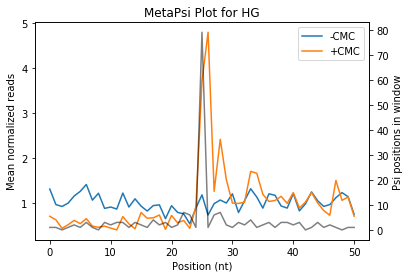

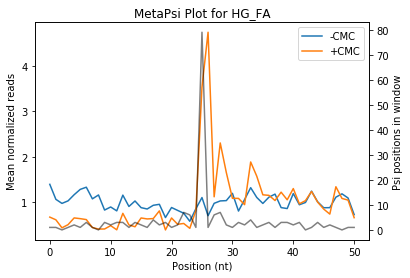

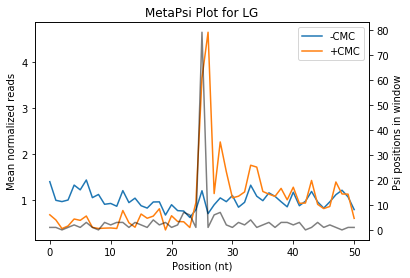

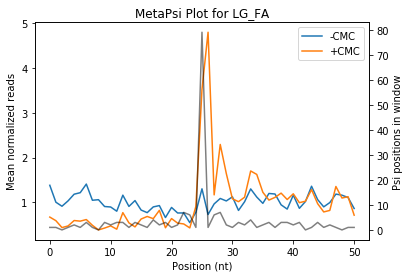

In [35]:
for exp_name, cmc_sample, input_sample in zip(exp_names, cmc_samples, input_samples):
    metapsi(ref_df, exp_name, cmc_sample, input_sample, rrna_to_known, plots_folder, ws=25, show_plot=True)

In [36]:
def _roc(ref_df, col, rrna_to_known):
    '''
    Given: dataframe and a particular column
    Calculate the roc curve for that column and the known sites
    Returns: fpr, tpr and roc_auc_score for plotting
    '''
    # the known list is the same for everything so just do that once
    y_true = []
    y_score = []
    for rrna in rrnas:
        known = rrna_to_known[rrna]
        rrna_length = len(ref_df[rrna]) # since last position isn't scored
        y_true += [1 if i in known else 0 for i in range(1,rrna_length)]
        y_score += list(ref_df[rrna][col][:-1])
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    roc_auc_score = metrics.roc_auc_score(y_true, y_score)
    return fpr, tpr, roc_auc_score

In [40]:
def roc(ref_df, cols, exp_name, labels, rrna_to_known):
    '''
    Given: list of columns and corresponding labels
    Make a ROC plot for each of the columns
    '''
    fig, ax = plt.subplots()
    
    for col, metric in zip(cols, labels):
        fpr, tpr, roc_auc_score = _roc(ref_df, col, rrna_to_known)
        ax.plot(fpr, tpr, label=metric+f' ({roc_auc_score:.2f})')
    ax.legend()
    ax.set_title(exp_name)
    ax.set_ylabel('True positive rate (sensitivity)')
    ax.set_xlabel('False positive rate (1-specificity)')

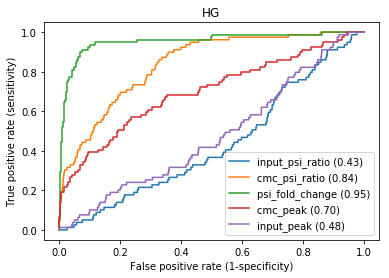

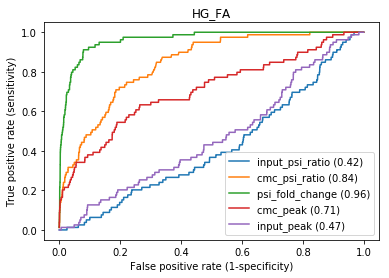

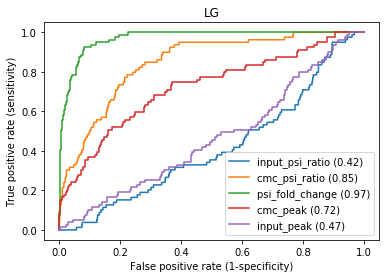

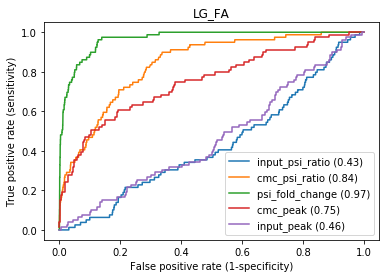

In [44]:
labels = ('input_psi_ratio','cmc_psi_ratio','psi_fold_change', 'cmc_peak', 'input_peak')
sample_cols = (input_psi_ratios, cmc_psi_ratios, exp_psi_fold_changes, exp_peaks, exp_input_peaks)
for c in zip(*sample_cols, exp_names):
    cols = c[:-1]
    exp_name = c[-1]
    roc(ref_df, cols, exp_name, labels, rrna_to_known)

In [45]:
def peak_plots(df, exp_values, ref_name, known_sites, ws, output_folder, title, y_label, show_plot=False):
    '''
    Given:
    df: dataframe for a particular ref gene
    exp_values: column names for sample, for example peak values or psi fold-change values
    ref_name: reference gene
    known_sites: list of known positions
    ws: window size (used only for Carlile peak values)
    output_folder: where plots saved
    title: title of plot
    y_label: y-label of plot
    show_plot: set to False to hide plots in notebook (they will still be saved)
    Plots values for each position for all experiments in same plots
    '''  
    U = df[df.Sequence=='T']
    ACG = df[df.Sequence!='T']
    
    U_known = U.loc[known_sites]
    U_unknown = U.loc[~U.index.isin(known_sites)]
    ACG_unknown = ACG.loc[~ACG.index.isin(known_sites)]
    
    # use order of cats to set zorder
    cats = ((ACG_unknown, 'gray', '.', 'ACG bases'),
            (U_unknown, 'red', '.', 'U bases (not known to be Psi)'),
            (U_known, 'blue', '+', 'U bases known to be Psi'),
            )
    
    fig, ax = plt.subplots(figsize=(24,8))
    for zorder, (d, color, style, label) in enumerate(cats):
        for exp_peak in exp_peaks:
            x_vals = d.index
            y_vals = d[exp_values]
            ax.plot(x_vals, y_vals, style, color=color, label = label, zorder = zorder)
            label = ''
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(y_label,fontsize=14)
    ax.set_xlabel('nt position in gene',fontsize=14)
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left",fontsize=14)
    fig.subplots_adjust(right=0.8)
    filename = os.path.join(output_folder, '_'.join(title.split())+'.png')
    fig.savefig(filename)
    print(f'{filename} was saved...')
    
    if not show_plot:
        plt.close(fig)

In [48]:
for ref_name, df, in ref_df.items():
    known_sites = rrna_to_known.get(ref_name, []) # if no known sites given, use empty list
    peak_plots(df, exp_peaks, ref_name, known_sites, window_size, plots_folder, 
               f'{ref_name} Peak values ws{window_size}', 'Peak value', show_plot=False)
    peak_plots(df, exp_psi_fold_changes, ref_name, known_sites, window_size, plots_folder, 
               f'{ref_name} Psi fold-change', 'Psi fold-change', show_plot=False)

./results/plots/18S_Peak_values_ws20.png was saved...
./results/plots/18S_Psi_fold-change.png was saved...
./results/plots/28S_Peak_values_ws20.png was saved...
./results/plots/28S_Psi_fold-change.png was saved...
./results/plots/5-8S_Peak_values_ws20.png was saved...
./results/plots/5-8S_Psi_fold-change.png was saved...


In [51]:
def _plot_line(ax, x1, y1, x2, y2):
    '''
    Helper function for compare_exps to plot lines
    '''
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot((x1,x2),(y1,y2),'--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [52]:
def _center_ylim(ax):
    '''
    Helper function for compare_exps to adjust ylim
    '''
    max_ylim = max([abs(i) for i in ax.get_ylim()])
    ax.set_ylim(-max_ylim, max_ylim)

In [102]:
def compare_exps(df, exp_names, exp_values, ref_name, known_sites, ws, peak_or_fc, output_folder, 
                 by_position=True, cutoff=None, log_scale=None, show_plot=True):
    '''
    Given:
    d: dataframe for a particular ref gene
    exp_values: column names for sample, for example peak values or psi fold-change values
    ref_name: reference gene
    known_sites: list of known positions
    output_folder: folder to save plots to
    peak_or_fc: 'peak' if using Carlile peaks, 'fc' is using Schwartz psi fold-change
    by_position: if True plot expA-expB for each nt position, else plot scatter of expA vs expB
    cutoff: if True only include positions with peak >= cutoff under ALL experiments
    log_scale: take log of peak values, for example can use np.log2, np.log10, np.log
    show_plot: if False do not show plots in notebook (they will still be saved to output_folder)
    
    Make plots comparing each pair of experiments
    '''
    if peak_or_fc not in ('peak','fc'):
        raise SystemError(f'peak_or_fc must be either peak or fc instead of {peak_or_fc}')
    
    if cutoff is not None:
        df = df[(df[exp_peaks]>cutoff).all(axis='columns')]
        # apply cutoff to ALL experiments at that position
        # alternative is to just apply to each pair of experiments
        
        # need to get rid of known_sites that didn't pass cutoff
        # otherwise pandas generates a warning when try to use .loc
        known_sites = [site for site in known_sites if site in df.index]
        
    U = df[df.Sequence=='T']
    ACG = df[df.Sequence!='T']
    
    U_known = U.loc[known_sites]
    U_unknown = U.loc[~U.index.isin(known_sites)]
    ACG_unknown = ACG.loc[~ACG.index.isin(known_sites)]
    
    # use order of cats to set zorder
    cats = ((ACG_unknown, 'gray', '.', 'ACG bases'),
            (U_unknown, 'red', '.', 'U bases (not known to be Psi)'),
            (U_known, 'blue', '+', 'U bases known to be Psi'),
            )
    
    nrows = ncols = len(exp_peaks) + 1
    
    fig, axes = plt.subplots(figsize=(12,12),nrows=nrows,ncols=ncols,sharex=True,sharey=True)
    
    min_val = 0 # keep track of min value so lower left will be on y=x if by_position is False
    
    for row, (exp_a, a_name) in enumerate(zip(exp_peaks, exp_names)):
        # label the rows
        axes[row+1,0].text(0.5, 0.5, a_name, 
                           transform=axes[row+1,0].transAxes, fontsize=16,
                           ha='center',va='center')
        
        for col, (exp_b, b_name) in enumerate(zip(exp_peaks, exp_names)):
            if row == 0: # label the columns
                axes[row, col+1].text(0.5, 0.5, b_name + '\n'+ ref_name, 
                                      transform=axes[row,col+1].transAxes, fontsize=16,
                                      ha='center',va='center')
            if row == col: # don't plot same sample verse itself
                continue

            for zorder, (d, color, style, label) in enumerate(cats):
                a_vals, b_vals = d[exp_a], d[exp_b]
                if log_scale:
                    a_vals, b_vals = log_scale(a_vals), log_scale(b_vals)
         
                if by_position:
                    x_vals = d.index # x axis if nt position in gene
                    y_vals = (a_vals - b_vals)/np.sqrt(2) # sqrt(2) to get distance to y=x diagonal
                else:
                    x_vals, y_vals = b_vals, a_vals # plot a vs b
                    min_val = min(min(x_vals), min(y_vals), min_val)

                ax = axes[row+1,col+1]
                ax.plot(x_vals, y_vals, style, color=color, label=label, zorder=zorder)
    
    if peak_or_fc == 'peak':
        title = f'Peak value\n{ref_name}'
    elif peak_or_fc == 'fc':
        title = f'Psi fold-change\n{ref_name}'
    axes[0,0].text(.5,.5,title,fontsize=14,transform=axes[0,0].transAxes,ha='center',va='center')

    # loop thru again to plot lines and adjust axes limits
    for row, (exp_a, a_name) in enumerate(zip(exp_peaks, exp_names)):
        for col, (exp_b, b_name) in enumerate(zip(exp_peaks, exp_names)):
            
            if row == col:
                continue
            ax = axes[row+1, col+1]
            
            if by_position: 
                _center_ylim(ax) # center so that 0 is in middle of y-axis
                _plot_line(ax, -1000,0,10000,0) # plot horizontal y=0 line
                ax.set_xlim(-.1*df.index.max(),df.index.max()+.1*df.index.max())
                # add extra padding to left and right when setting xlim
                
                ax.text(.02,.90,f'{a_name} > {b_name}',fontsize=14,transform=ax.transAxes)
                ax.text(.02,.05,f'{b_name} > {a_name}',fontsize=14,transform=ax.transAxes)
            else:
                _plot_line(ax, -100,-100,100,100) # plot y=x diagonal
                ax.set_xlim(left=min_val) # make sure starts at 0,0 origin
                ax.set_ylim(bottom=min_val)               
    
    # remove the self vs self axes 
    for i in range(nrows):
        axes[i,i].set_axis_off()
            
    log_scale_name = ''
    if log_scale:
        log_scale_name = '_' + log_scale.__str__().split()[1].split('\'')[1]
    if by_position:
        plot_type = 'by_position'
    else:
        plot_type = 'scatter'
    
    if peak_or_fc == 'peak':
        filename = f'{ref_name}_compare_peak_{plot_type}_cutoff{cutoff}{log_scale_name}_ws{ws}.png'
    elif peak_or_fc == 'fc':
        filename = f'{ref_name}_compare_fold_change_{plot_type}_cutoff{cutoff}{log_scale_name}.png'
    fig.savefig(os.path.join(output_folder, filename))
    print(f'{filename} was saved...')
    
    if not show_plot:
        plt.close(fig)

In [106]:
for ref_name, df, in ref_df.items():
    known_sites = rrna_to_known.get(ref_name, []) # if no known sites given, use empty list
    compare_exps(df, exp_names, exp_peaks, ref_name, known_sites, window_size, 'peak',
                 plots_folder, by_position=True, cutoff=0,log_scale=None,show_plot=False)
    compare_exps(df, exp_names, exp_psi_fold_changes, ref_name, known_sites, window_size, 'fc', 
                 plots_folder, by_position=True, cutoff=0,log_scale=None,show_plot=False)

18S_compare_peak_by_position_cutoff_0_ws20.png was saved...
18S_compare_fold_change_by_position_cutoff_0.png was saved...
28S_compare_peak_by_position_cutoff_0_ws20.png was saved...
28S_compare_fold_change_by_position_cutoff_0.png was saved...
5-8S_compare_peak_by_position_cutoff_0_ws20.png was saved...
5-8S_compare_fold_change_by_position_cutoff_0.png was saved...
